https://viso.ai/deep-learning/vision-transformer-vit/

https://www.kaggle.com/code/raufmomin/vision-transformer-vit-fine-tuning/notebook

https://www.kaggle.com/code/raufmomin/vision-transformer-vit-from-scratch/notebook

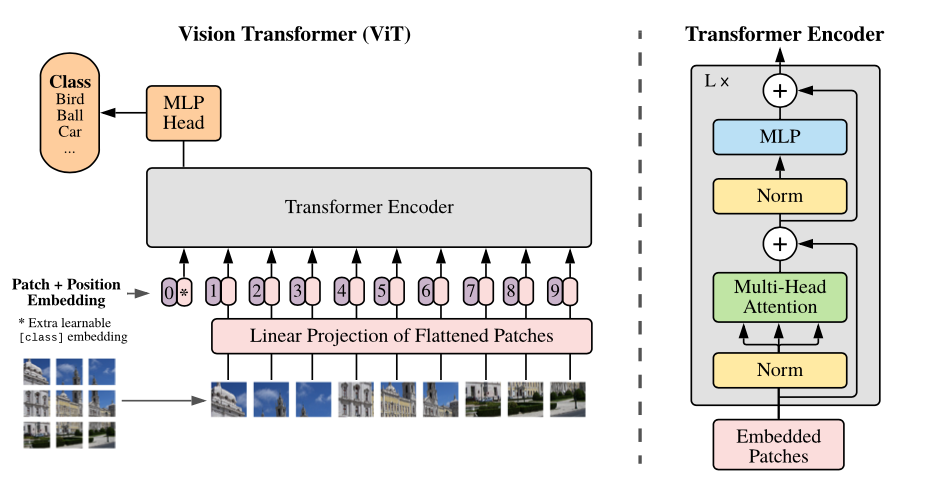

In [ ]:
!pip install -U mxnet-cu101==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
!nvidia-smi

Wed Mar 22 13:34:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.12.0


In [9]:
from google.colab import drive
drive.mount('/content/derive')

Drive already mounted at /content/derive; to attempt to forcibly remount, call drive.mount("/content/derive", force_remount=True).


In [11]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = '/content/derive/MyDrive/Dataset2_split/train'
TEST_PATH = '/content/derive/MyDrive/Dataset2_split/val'

#TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpg')





In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = '/content/derive/MyDrive/Dataset3_split/train'
TEST_PATH = '/content/derive/MyDrive/Dataset3_split/val'

#TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpg')


classes = {0 : "Brown_rust",
           1 : "Healthy",
           2 : "Yellow_rust"
}

In [12]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [13]:
from tensorflow import keras

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          #validation_split = 0.2,
                                                          preprocessing_function = data_augment)

train_gen = datagen.flow_from_directory(directory= TRAIN_PATH,
                                        
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = datagen.flow_from_directory(directory= TEST_PATH,
                                        
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode ='categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))
"""valid_gen = keras.utils.image_dataset_from_directory(
    directory= TEST_PATH,
    labels="inferred",
    class_names='categorical',
    #color_mode="rgb",
    batch_size= BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle= False,
    seed=1
)"""

test_gen = datagen.flow_from_directory(directory= TEST_PATH,
                                       
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))                                                                           

Found 4743 images belonging to 4 classes.
Found 1189 images belonging to 4 classes.
Found 1189 images belonging to 4 classes.


In [ ]:
from tensorflow import keras

train_gen = keras.utils.image_dataset_from_directory(
    directory='/content/derive/MyDrive/Dataset3_split/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))
valid_gen = keras.utils.image_dataset_from_directory(
    directory='/content/derive/MyDrive/Dataset3_split/val/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))

Found 2942 files belonging to 3 classes.
Found 737 files belonging to 3 classes.


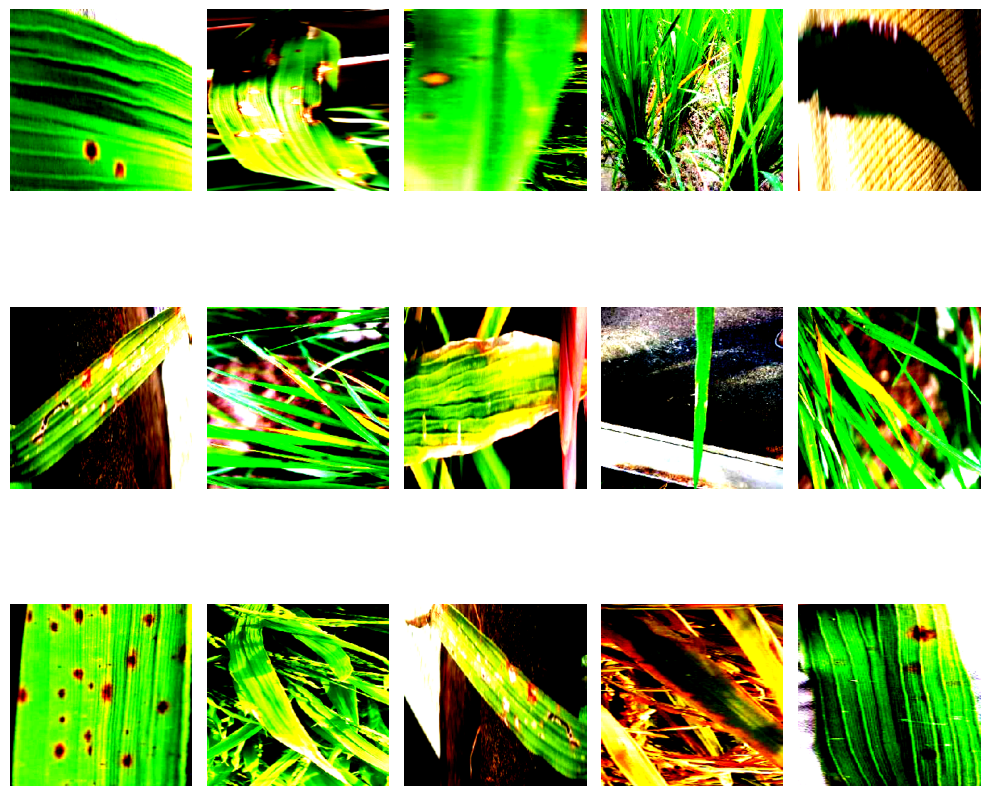

In [14]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
!pip install tensorflow-addons
!pip install --quiet vit-keras

from vit_keras import vit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


https://keras.io/examples/vision/mobilevit/

In [17]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)

1/1 [==============================] - 9s 9s/step


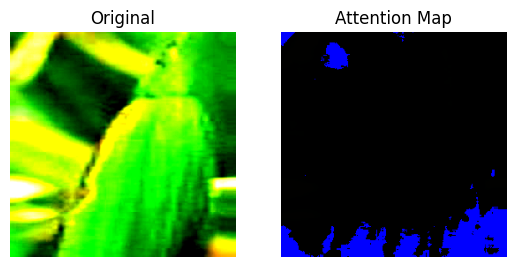

In [18]:
from vit_keras import visualize

x = test_gen.next()
image = x[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [20]:
import tensorflow as tf
import tensorflow.keras as tk
import tensorflow_addons as tfa

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87466752  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 11)                8459      
                                                                 
 batch_normalization_3 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 4)          

In [21]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

h=model.fit(x = train_gen,
          #steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          #validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5', save_weights_only = True)                                                 

Epoch 1/7
297/297 [==============================] - ETA: 0s - loss: 0.9000 - accuracy: 0.8218
Epoch 1: val_accuracy improved from -inf to 0.99664, saving model to ./model.hdf5
297/297 [==============================] - 2578s 9s/step - loss: 0.9000 - accuracy: 0.8218 - val_loss: 0.6716 - val_accuracy: 0.9966 - lr: 1.0000e-04
Epoch 2/7
297/297 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.9878
Epoch 2: val_accuracy improved from 0.99664 to 1.00000, saving model to ./model.hdf5
297/297 [==============================] - 168s 567ms/step - loss: 0.6594 - accuracy: 0.9878 - val_loss: 0.6333 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/7
297/297 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.9968
Epoch 3: val_accuracy did not improve from 1.00000
297/297 [==============================] - 166s 560ms/step - loss: 0.6316 - accuracy: 0.9968 - val_loss: 0.6197 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/7
297/297 [========================

TypeError: ignored

47/47 [==============================] - 21s 379ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       226
           1       1.00      1.00      1.00       279
           2       1.00      1.00      1.00       232

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737



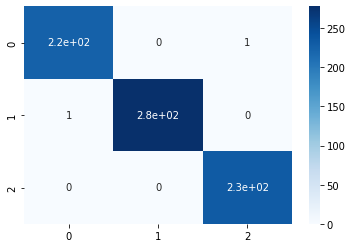

In [ ]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(#figsize = (6, 6)
)
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(valid_gen)
y_pred=np.argmax(y_pred,axis=1)
test_y=valid_gen.classes
#get classification report
target_names =  ['Brown_rust','Healthy','Yellow_rust']

print(classification_report(y_pred,test_y, target_names=target_names))
cf_matrix=confusion_matrix(test_y, y_pred)
#get confusion matrix
print(confusion_matrix(test_y, y_pred))

47/47 [==============================] - 26s 544ms/step
              precision    recall  f1-score   support

  Brown_rust       1.00      1.00      1.00       226
     Healthy       1.00      1.00      1.00       278
 Yellow_rust       1.00      1.00      1.00       233

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

[[225   0   1]
 [  1 278   0]
 [  0   0 232]]


In [ ]:
cf_matrix=confusion_matrix(test_y, y_pred)

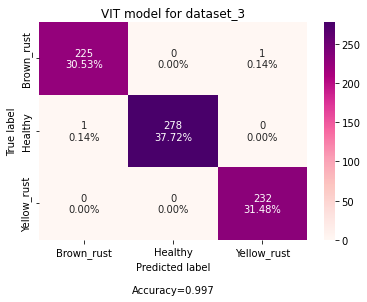

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories =  ['Brown_rust','Healthy','Yellow_rust']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='RdPu',
                       #figsize=(10,6)
                       title='VIT model for dataset_3',#figsize=(10,5)
                       ) 

In [ ]:
#Get the accuracy score
batch_size=32
test_score = model.evaluate_generator(valid_gen, batch_size)


print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 99.41%
[INFO] Loss:  0.49658429622650146


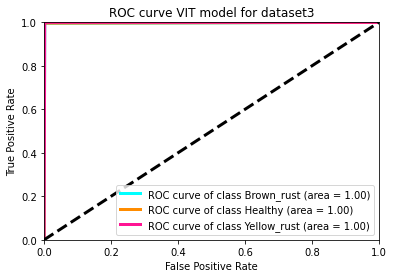

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Plot linewidth.
lw = 3
classes=np.unique(test_y)
n_classes=classes.shape[0]
y_test = label_binarize(test_y, classes=np.unique(test_y))
y_pred = label_binarize(y_pred, classes=np.unique(y_pred))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(),y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
class1=['Brown_rust','Healthy','Yellow_rust']
colors = cycle(['aqua', 'darkorange', 'deeppink','deeppink','red','green','yellow','pink','coral'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class1[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve VIT model for dataset3')
plt.legend(loc="lower right")
plt.show()


47/47 [==============================] - 20s 424ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       226
           1       1.00      1.00      1.00       279
           2       0.99      1.00      0.99       232

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737



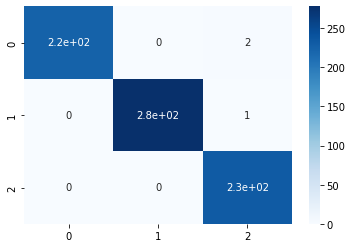

In [ ]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(#figsize = (6, 6)
)
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))